In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2023-03-05 05:25:06.423151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Generator:
    def __init__(self, input_shape, output_shape, hidden_sizes):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_sizes = hidden_sizes
        self.model = self.build_model()

    def build_model(self):
        input_layer = Input(shape=self.input_shape)
        x = Dense(self.hidden_sizes[0])(input_layer)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        for size in self.hidden_sizes[1:]:
            x = Dense(size)(x)
            x = LeakyReLU()(x)
            x = BatchNormalization()(x)
        output_layer = Dense(self.output_shape[0], activation='sigmoid')(x)
        model = Model(input_layer, output_layer)
        return model

    def generate_samples(self, n_samples):
        noise = np.random.normal(0, 1, size=(n_samples,) + self.input_shape)
        generated_samples = self.model.predict(noise)
        return generated_samples

In [3]:
class Discriminator:
    def __init__(self, input_shape, hidden_sizes):
        self.input_shape = input_shape
        self.hidden_sizes = hidden_sizes
        self.model = self.build_model()
        self.model.compile(loss='binary_crossentropy', optimizer=Adam())

    def build_model(self):
        input_layer = Input(shape=self.input_shape)
        x = Dense(self.hidden_sizes[0])(input_layer)
        x = LeakyReLU()(x)
        for size in self.hidden_sizes[1:]:
            x = Dense(size)(x)
            x = LeakyReLU()(x)
        output_layer = Dense(1, activation='sigmoid')(x)
        model = Model(input_layer, output_layer)
        return model

In [4]:
class GAN:
    def __init__(self, generator, discriminator, learning_rate):
        self.generator = generator
        self.discriminator = discriminator
        self.learning_rate = learning_rate
        self.model = self.build_model()

    def build_model(self):
        self.discriminator.model.trainable = False
        gan_input = Input(shape=self.generator.input_shape)
        gan_output = self.discriminator.model(self.generator.model(gan_input))
        model = Model(gan_input, gan_output)
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.learning_rate))
        return model

    def train(self, real_data, epochs, batch_size):
        history = {"d_loss": [], "g_loss": []}

        for epoch in range(epochs):
            # Sample a batch of real data
            real_data_batch = real_data[np.random.choice(len(real_data), batch_size, replace=False)]

            # Train the discriminator on the real data
            discriminator_loss_real = self.discriminator.model.train_on_batch(real_data_batch, np.ones((batch_size, 1)))

            # Generate a batch of synthetic data using the generator
            synthetic_data_batch = self.generator.generate_samples(batch_size)

            # Train the discriminator on the synthetic data
            discriminator_loss_synthetic = self.discriminator.model.train_on_batch(synthetic_data_batch, np.zeros((batch_size, 1)))

            # Calculate the average discriminator loss
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_synthetic)

            # Train the generator to fool the discriminator
            generator_loss = self.model.train_on_batch(np.random.normal(0, 1, size=(batch_size,) + self.generator.input_shape), np.ones((batch_size, 1)))

            history["d_loss"].append(discriminator_loss)
            history["g_loss"].append(generator_loss)

            # Print the progress
            if epoch % 1 == 0:
                print(f'Epoch: {epoch}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}')
        return history

In [5]:
# Load the real dataset
dataset = pd.read_csv('processed_diabetic_data.csv')

# Define the name of the target column
X_real = dataset.iloc[1:,2:]

In [6]:
# dataset = pd.read_csv('diabetes_csv.csv')
# X_real = dataset.iloc[1:,:-1]
# X_real

In [7]:
# import seaborn as sns


# fig, axes = plt.subplots(nrows = 3, ncols = 3)
# fig.set_size_inches(15, 100)

# for i, column in enumerate(X_real.columns, 1):
#     plt.subplot(16,3,i)
#     sns.histplot(X_real[column])

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X_real)

# Set the hyperparameters
input_shape = (48,)
output_shape = (48,)
hidden_sizes = [64, 64]
learning_rate = 0.001
epochs = 1000
batch_size = 32

# Create the generator and discriminator models
generator = Generator(input_shape, output_shape, hidden_sizes)
discriminator = Discriminator(input_shape, hidden_sizes)

# Create the GAN model
gan = GAN(generator, discriminator, learning_rate)

# Train the GAN on the dataset
history = gan.train(X, epochs, batch_size)

2023-03-05 05:25:13.397344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 203ms/step
Epoch: 0, Discriminator Loss: 0.7790674269199371, Generator Loss: 0.5514849424362183
1/1 [==============================] - 0s 45ms/step
Epoch: 1, Discriminator Loss: 0.7020482420921326, Generator Loss: 0.6266348958015442
1/1 [==============================] - 0s 50ms/step


2023-03-05 05:25:17.065935: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 2, Discriminator Loss: 0.6573607325553894, Generator Loss: 0.7146439552307129
1/1 [==============================] - 0s 39ms/step
Epoch: 3, Discriminator Loss: 0.6037485897541046, Generator Loss: 0.8014392852783203
1/1 [==============================] - 0s 37ms/step
Epoch: 4, Discriminator Loss: 0.5730181038379669, Generator Loss: 0.8945732116699219
1/1 [==============================] - 0s 51ms/step
Epoch: 5, Discriminator Loss: 0.5334799885749817, Generator Loss: 0.9838598966598511
1/1 [==============================] - 0s 44ms/step
Epoch: 6, Discriminator Loss: 0.501871719956398, Generator Loss: 1.090186595916748
1/1 [==============================] - 0s 44ms/step
Epoch: 7, Discriminator Loss: 0.4781474173069, Generator Loss: 1.1852567195892334
1/1 [==============================] - 0s 41ms/step
Epoch: 8, Discriminator Loss: 0.4558410942554474, Generator Loss: 1.28114914894104
1/1 [==============================] - 0s 47ms/step
Epoch: 9, Discriminator Loss: 0.4447270780801773

2023-03-05 05:25:18.566936: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 10, Discriminator Loss: 0.42265862226486206, Generator Loss: 1.4848313331604004
1/1 [==============================] - 0s 42ms/step
Epoch: 11, Discriminator Loss: 0.40409791469573975, Generator Loss: 1.5589938163757324
1/1 [==============================] - 0s 44ms/step
Epoch: 12, Discriminator Loss: 0.37688226997852325, Generator Loss: 1.673080563545227
1/1 [==============================] - 0s 53ms/step
Epoch: 13, Discriminator Loss: 0.35375769436359406, Generator Loss: 1.7486498355865479
1/1 [==============================] - 0s 44ms/step
Epoch: 14, Discriminator Loss: 0.33971844613552094, Generator Loss: 1.8558523654937744
1/1 [==============================] - 0s 49ms/step
Epoch: 15, Discriminator Loss: 0.32478533685207367, Generator Loss: 1.9431567192077637
1/1 [==============================] - 0s 51ms/step
Epoch: 16, Discriminator Loss: 0.3032086491584778, Generator Loss: 2.0400354862213135
1/1 [==============================] - 0s 50ms/step
Epoch: 17, Discriminator Loss

2023-03-05 05:25:26.333130: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 88ms/step
Epoch: 56, Discriminator Loss: 0.02011548075824976, Generator Loss: 4.76300048828125
1/1 [==============================] - 0s 45ms/step
Epoch: 57, Discriminator Loss: 0.039924176409840584, Generator Loss: 4.998284339904785
1/1 [==============================] - 0s 41ms/step
Epoch: 58, Discriminator Loss: 0.021161689423024654, Generator Loss: 5.213047027587891
1/1 [==============================] - 0s 41ms/step
Epoch: 59, Discriminator Loss: 0.01521324459463358, Generator Loss: 5.210363388061523
1/1 [==============================] - 0s 41ms/step
Epoch: 60, Discriminator Loss: 0.020540867233648896, Generator Loss: 5.267772674560547
1/1 [==============================] - 0s 46ms/step
Epoch: 61, Discriminator Loss: 0.016623181756585836, Generator Loss: 5.443931579589844
1/1 [==============================] - 0s 37ms/step
Epoch: 62, Discriminator Loss: 0.018425513990223408, Generator Loss: 5.459676265716553
1/1 [=========================

2023-03-05 05:25:35.650002: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 109, Discriminator Loss: 0.03675621747970581, Generator Loss: 12.03862190246582
1/1 [==============================] - 0s 36ms/step
Epoch: 110, Discriminator Loss: 0.032052164897322655, Generator Loss: 11.088109970092773
1/1 [==============================] - 0s 46ms/step
Epoch: 111, Discriminator Loss: 0.03189597185701132, Generator Loss: 12.000864028930664
1/1 [==============================] - 0s 37ms/step
Epoch: 112, Discriminator Loss: 0.03940249793231487, Generator Loss: 12.113397598266602
1/1 [==============================] - 0s 37ms/step
Epoch: 113, Discriminator Loss: 0.04912239033728838, Generator Loss: 12.103748321533203
1/1 [==============================] - 0s 36ms/step
Epoch: 114, Discriminator Loss: 0.031818609684705734, Generator Loss: 12.571606636047363
1/1 [==============================] - 0s 36ms/step
Epoch: 115, Discriminator Loss: 0.04149377532303333, Generator Loss: 11.788640975952148
1/1 [==============================] - 0s 41ms/step
Epoch: 116, Discrim

2023-03-05 05:25:44.690958: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 46ms/step
Epoch: 167, Discriminator Loss: 0.18919441848993301, Generator Loss: 11.142860412597656
1/1 [==============================] - 0s 44ms/step
Epoch: 168, Discriminator Loss: 0.16066724807024002, Generator Loss: 10.167108535766602
1/1 [==============================] - 0s 37ms/step
Epoch: 169, Discriminator Loss: 0.11999943107366562, Generator Loss: 11.418460845947266
1/1 [==============================] - 0s 33ms/step
Epoch: 170, Discriminator Loss: 0.17229001224040985, Generator Loss: 8.872445106506348
1/1 [==============================] - 0s 36ms/step
Epoch: 171, Discriminator Loss: 0.13135474175214767, Generator Loss: 11.200675964355469
1/1 [==============================] - 0s 36ms/step
Epoch: 172, Discriminator Loss: 0.11317159235477448, Generator Loss: 10.47006607055664
1/1 [==============================] - 0s 33ms/step
Epoch: 173, Discriminator Loss: 0.14667115733027458, Generator Loss: 9.059412002563477
1/1 [==================

2023-03-05 05:25:47.272964: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 181, Discriminator Loss: 0.18957150354981422, Generator Loss: 8.551689147949219
1/1 [==============================] - 0s 37ms/step
Epoch: 182, Discriminator Loss: 0.07450337707996368, Generator Loss: 8.585994720458984
1/1 [==============================] - 0s 37ms/step
Epoch: 183, Discriminator Loss: 0.09911180660128593, Generator Loss: 8.560370445251465
1/1 [==============================] - 0s 38ms/step
Epoch: 184, Discriminator Loss: 0.15520669147372246, Generator Loss: 9.361392974853516
1/1 [==============================] - 0s 37ms/step
Epoch: 185, Discriminator Loss: 0.08295819908380508, Generator Loss: 8.314149856567383
1/1 [==============================] - 0s 40ms/step
Epoch: 186, Discriminator Loss: 0.13936994969844818, Generator Loss: 8.816418647766113
1/1 [==============================] - 0s 36ms/step
Epoch: 187, Discriminator Loss: 0.0596128236502409, Generator Loss: 8.738199234008789
1/1 [==============================] - 0s 46ms/step
Epoch: 188, Discriminator Lo

2023-03-05 05:26:33.469096: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 449, Discriminator Loss: 0.35395288467407227, Generator Loss: 1.3337332010269165
1/1 [==============================] - 0s 37ms/step
Epoch: 450, Discriminator Loss: 0.2999022379517555, Generator Loss: 1.2872653007507324
1/1 [==============================] - 0s 40ms/step
Epoch: 451, Discriminator Loss: 0.35657505691051483, Generator Loss: 1.4036426544189453
1/1 [==============================] - 0s 37ms/step
Epoch: 452, Discriminator Loss: 0.5199034214019775, Generator Loss: 1.4329156875610352
1/1 [==============================] - 0s 36ms/step
Epoch: 453, Discriminator Loss: 0.408616840839386, Generator Loss: 1.393496036529541
1/1 [==============================] - 0s 38ms/step
Epoch: 454, Discriminator Loss: 0.5683562010526657, Generator Loss: 1.2045083045959473
1/1 [==============================] - 0s 38ms/step
Epoch: 455, Discriminator Loss: 0.5896596312522888, Generator Loss: 1.3344690799713135
1/1 [==============================] - 0s 38ms/step
Epoch: 456, Discriminator L

2023-03-05 05:26:49.856290: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 548, Discriminator Loss: 0.3332080990076065, Generator Loss: 2.043426275253296
1/1 [==============================] - 0s 46ms/step
Epoch: 549, Discriminator Loss: 0.3547765165567398, Generator Loss: 1.7521841526031494
1/1 [==============================] - 0s 37ms/step
Epoch: 550, Discriminator Loss: 0.3722357600927353, Generator Loss: 1.8692165613174438
1/1 [==============================] - 0s 35ms/step
Epoch: 551, Discriminator Loss: 0.41195543110370636, Generator Loss: 1.8453782796859741
1/1 [==============================] - 0s 36ms/step
Epoch: 552, Discriminator Loss: 0.29409362375736237, Generator Loss: 1.650827407836914
1/1 [==============================] - 0s 34ms/step
Epoch: 553, Discriminator Loss: 0.34802282601594925, Generator Loss: 1.8251073360443115
1/1 [==============================] - 0s 37ms/step
Epoch: 554, Discriminator Loss: 0.3185683414340019, Generator Loss: 1.807663917541504
1/1 [==============================] - 0s 39ms/step
Epoch: 555, Discriminator L

2023-03-05 05:26:52.384972: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 562, Discriminator Loss: 0.2900860011577606, Generator Loss: 2.0112740993499756
1/1 [==============================] - 0s 42ms/step
Epoch: 563, Discriminator Loss: 0.3473346680402756, Generator Loss: 2.087186574935913
1/1 [==============================] - 0s 34ms/step
Epoch: 564, Discriminator Loss: 0.295306071639061, Generator Loss: 1.9576828479766846
1/1 [==============================] - 0s 38ms/step
Epoch: 565, Discriminator Loss: 0.3209485709667206, Generator Loss: 2.154703378677368
1/1 [==============================] - 0s 37ms/step
Epoch: 566, Discriminator Loss: 0.41183289885520935, Generator Loss: 2.5214290618896484
1/1 [==============================] - 0s 32ms/step
Epoch: 567, Discriminator Loss: 0.3163680136203766, Generator Loss: 2.10503888130188
1/1 [==============================] - 0s 27ms/step
Epoch: 568, Discriminator Loss: 0.4149041175842285, Generator Loss: 2.168057680130005
1/1 [==============================] - 0s 31ms/step
Epoch: 569, Discriminator Loss: 

2023-03-05 05:27:02.758477: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 625, Discriminator Loss: 0.6625728905200958, Generator Loss: 0.9434256553649902
1/1 [==============================] - 0s 38ms/step
Epoch: 626, Discriminator Loss: 0.5295772552490234, Generator Loss: 0.8663316965103149
1/1 [==============================] - 0s 37ms/step
Epoch: 627, Discriminator Loss: 0.6249000728130341, Generator Loss: 1.089099645614624
1/1 [==============================] - 0s 37ms/step
Epoch: 628, Discriminator Loss: 0.6034213304519653, Generator Loss: 0.8593759536743164
1/1 [==============================] - 0s 42ms/step
Epoch: 629, Discriminator Loss: 0.5885613560676575, Generator Loss: 0.9431482553482056
1/1 [==============================] - 0s 35ms/step
Epoch: 630, Discriminator Loss: 0.5487737357616425, Generator Loss: 1.003259539604187
1/1 [==============================] - 0s 36ms/step
Epoch: 631, Discriminator Loss: 0.6134263277053833, Generator Loss: 0.9756131172180176
1/1 [==============================] - 0s 37ms/step
Epoch: 632, Discriminator Los

2023-03-05 05:27:34.839477: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 818, Discriminator Loss: 0.4700939357280731, Generator Loss: 1.295412540435791
1/1 [==============================] - 0s 34ms/step
Epoch: 819, Discriminator Loss: 0.4037128835916519, Generator Loss: 1.3145692348480225
1/1 [==============================] - 0s 41ms/step
Epoch: 820, Discriminator Loss: 0.3887277990579605, Generator Loss: 1.3391180038452148
1/1 [==============================] - 0s 35ms/step
Epoch: 821, Discriminator Loss: 0.4414817690849304, Generator Loss: 1.3163011074066162
1/1 [==============================] - 0s 35ms/step
Epoch: 822, Discriminator Loss: 0.4719959497451782, Generator Loss: 1.4764883518218994
1/1 [==============================] - 0s 38ms/step
Epoch: 823, Discriminator Loss: 0.38780513405799866, Generator Loss: 1.2327806949615479
1/1 [==============================] - 0s 35ms/step
Epoch: 824, Discriminator Loss: 0.4281723350286484, Generator Loss: 1.2856119871139526
1/1 [==============================] - 0s 39ms/step
Epoch: 825, Discriminator L

2023-03-05 05:27:54.271109: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 934, Discriminator Loss: 0.4445655643939972, Generator Loss: 1.2233943939208984
1/1 [==============================] - 0s 42ms/step
Epoch: 935, Discriminator Loss: 0.751939594745636, Generator Loss: 1.1307141780853271
1/1 [==============================] - 0s 37ms/step
Epoch: 936, Discriminator Loss: 0.3829437345266342, Generator Loss: 1.1173399686813354
1/1 [==============================] - 0s 38ms/step
Epoch: 937, Discriminator Loss: 0.4952530562877655, Generator Loss: 1.0336127281188965
1/1 [==============================] - 0s 40ms/step
Epoch: 938, Discriminator Loss: 0.48579588532447815, Generator Loss: 1.1329319477081299
1/1 [==============================] - 0s 34ms/step
Epoch: 939, Discriminator Loss: 0.4447576105594635, Generator Loss: 1.213235855102539
1/1 [==============================] - 0s 37ms/step
Epoch: 940, Discriminator Loss: 0.489449143409729, Generator Loss: 1.3109467029571533
1/1 [==============================] - 0s 41ms/step
Epoch: 941, Discriminator Los

2023-03-05 05:28:03.344323: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-03-05 05:28:03.393093: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 40ms/step
Epoch: 987, Discriminator Loss: 0.4962146580219269, Generator Loss: 1.0039308071136475
1/1 [==============================] - 0s 34ms/step
Epoch: 988, Discriminator Loss: 0.5965157747268677, Generator Loss: 1.1071006059646606
1/1 [==============================] - 0s 39ms/step
Epoch: 989, Discriminator Loss: 0.6203820109367371, Generator Loss: 1.127091646194458
1/1 [==============================] - 0s 39ms/step
Epoch: 990, Discriminator Loss: 0.5978554040193558, Generator Loss: 0.9583907723426819
1/1 [==============================] - 0s 34ms/step
Epoch: 991, Discriminator Loss: 0.5996831059455872, Generator Loss: 1.0132325887680054
1/1 [==============================] - 0s 46ms/step
Epoch: 992, Discriminator Loss: 0.524610847234726, Generator Loss: 0.9861143827438354
1/1 [==============================] - 0s 36ms/step
Epoch: 993, Discriminator Loss: 0.6613608598709106, Generator Loss: 0.9397649765014648
1/1 [========================

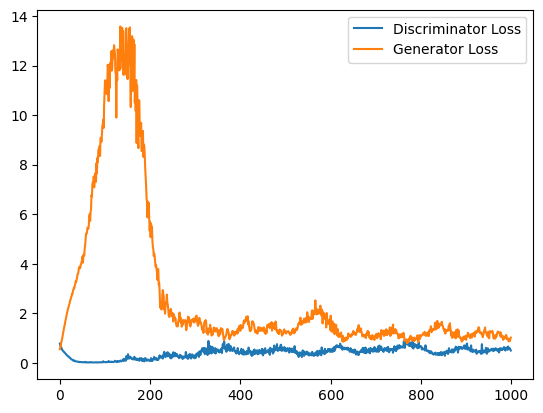

In [9]:
plt.plot(history["d_loss"], label="Discriminator Loss")
plt.plot(history["g_loss"], label="Generator Loss")
plt.legend()
plt.show()

In [10]:
n_samples = 10000
generated_samples = generator.generate_samples(n_samples)

synthetic_data = scaler.inverse_transform(generated_samples)

# Combine the synthetic data and the target column into a single DataFrame
synthetic_data = pd.DataFrame(synthetic_data, columns=X_real.columns)

313/313 [==============================] - 1s 3ms/step


(101765, 48) (10000, 48)


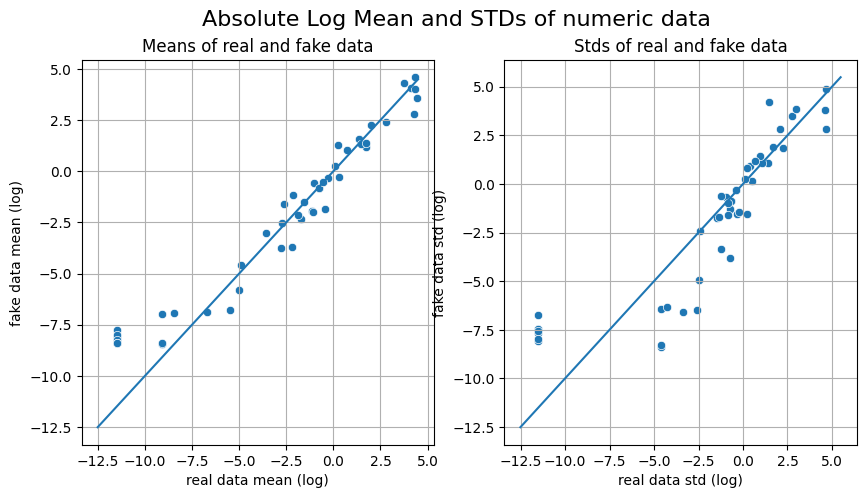

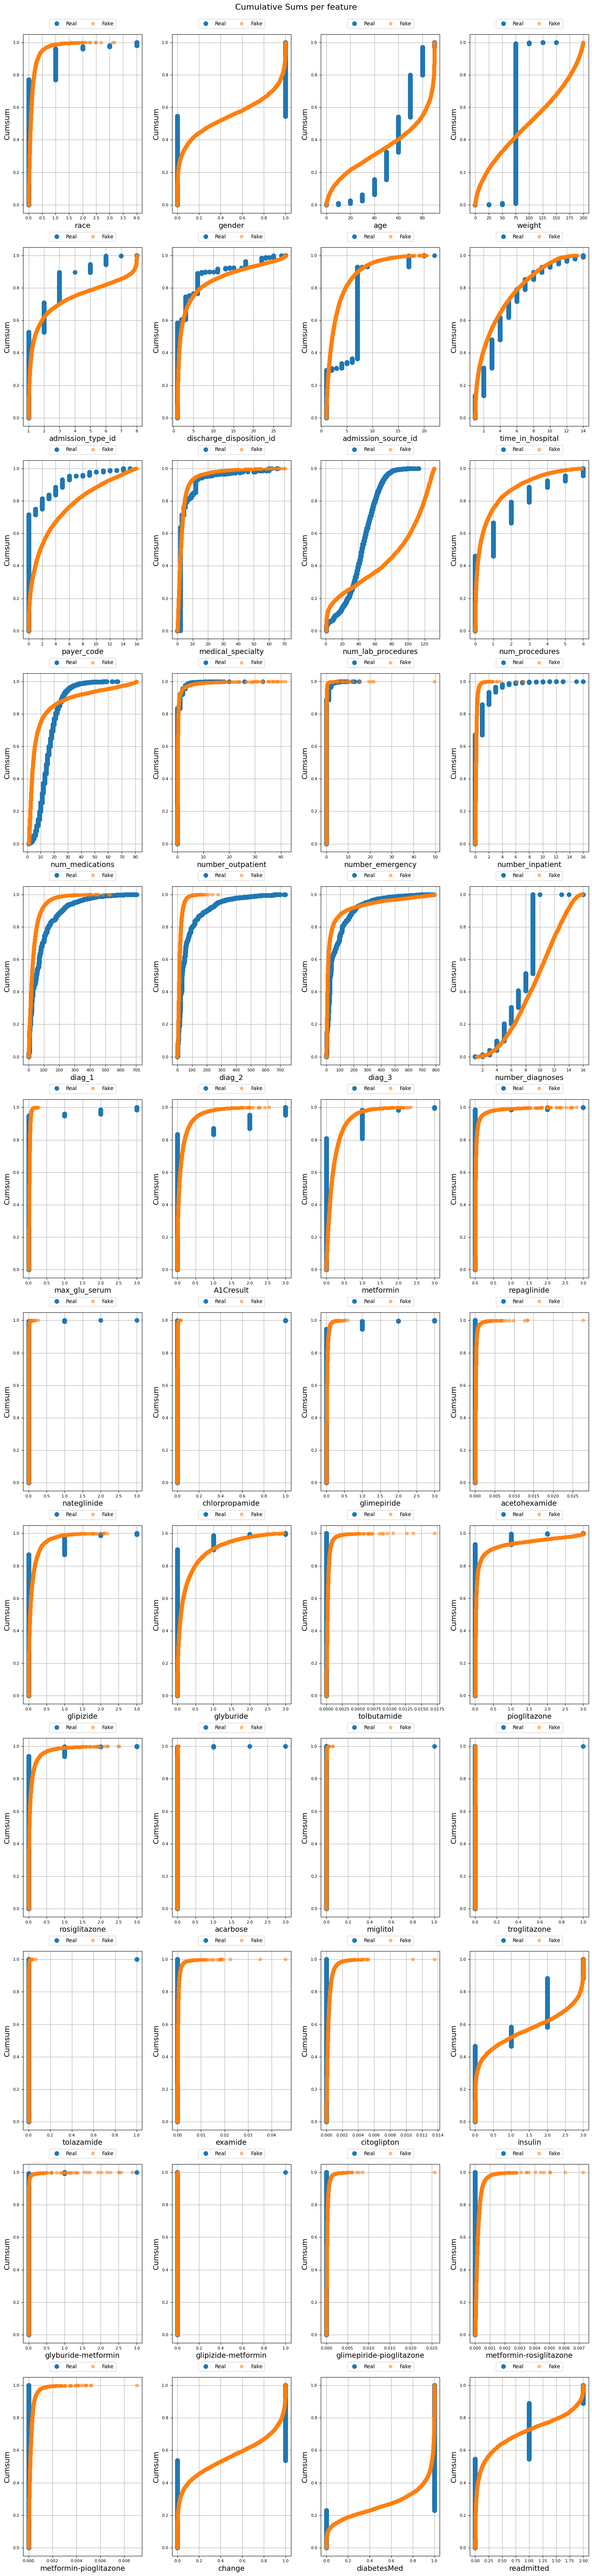

/home/ahmed/.local/lib/python3.10/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/home/ahmed/.local/lib/python3.10/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/home/ahmed/.local/lib/python3.10/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f431aa11990> (for post_execute):


KeyboardInterrupt: 

In [11]:
from table_evaluator import TableEvaluator

print(X_real.shape, synthetic_data.shape)

table_evaluator = TableEvaluator(X_real, synthetic_data)

table_evaluator.visual_evaluation()

In [12]:
import seaborn as sns


fig, axes = plt.subplots(nrows = 3, ncols = 3)
fig.set_size_inches(15, 100)

for i, column in enumerate(X_real.columns, 1):
    plt.subplot(16,3,i)
    sns.distplot(X_real[column])
    sns.distplot(synthetic_data[column])